# CISC5800: Machine Learning Final Project
### *Creating a Convolutional Neural Network using a Plant Leaf Diseases Training Dataset from Kaggle*
## By: Ryan Cruise, SJ

## General Flow of this Notebook:
1. Data Exploration
2. Initial Run of VGG-16 Model
3. Recreating "mock" VGG-16 Model
4. Testing different CNN Layers
5. Reducing Data to only 21 Classes and ~56,000 samples for less runtime and greater accuracy
6. Identifying Data Imbalance Problem
7. Using Class Weights to solve for imbalance
8. Creating Stratified K-Fold to solve for imbalance (different Jupyter-Notebook)
9. Honorable Mention: Augmented data function that I ended up not being able to use becasue it took up too much memory

In [22]:
#loading all the necessary packages for this project
import os

#silencing warnings from tensorflow re: gpu use
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from pathlib import Path
from PIL import Image
import glob
import time
import matplotlib.pyplot as plt
import seaborn as sns

#verify local GPU being used by Tensorflow
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Data Exploration

The data is from the Kaggle dataset "Plant Leaf Diseases Training Dataset" by Nirmal Sankalana. You can follow this link to the dataset: https://www.kaggle.com/datasets/nirmalsankalana/plant-diseases-training-dataset


This first block of code provides a preliminary look at the dataset and creates a dataframe that summarizes the classes. Even at this point it is apparent that there are issues with data imbalances.

In [20]:
#directory path of parent folder of all plant images
dir_path = "/home/ryan/plant_data/plant-diseases-training-dataset"
parent = Path(dir_path)

#list of names of each folder (class)
classes = [entry.name for entry in parent.iterdir() if entry.is_dir()] 
class_onehot = [x for x in range(len(classes))]

#creates a list of classes organized by plant healthy vs. unhealthy
#I considered dividing the plants by healthy vs. unhealthy to reduce the num. classes and improve accuracy
health_dir = []

#initialize empty class df to store classes and class counts
df_class = pd.DataFrame({'class': classes, 'y':class_onehot, 'plant': pd.NA, 'health': ['unhealthy'for x in range(len(classes))], 'count':np.nan})

#used for class weights in section 7
train_labels = []

#creates df of classes and thier counts
for cls in classes:
    #assigns class plant, health, and class count to each class
    p=Path(f'{dir_path}/{cls}')
    count = sum(1 for entry in p.rglob('*') if entry.is_file())
    df_class.loc[df_class['class'] == cls, 'count'] = count
    temp_list = [cls for x in range(count)] 
    train_labels = train_labels + temp_list #for use in class weights in section 7
    
    #assigns plant type
    split = cls.split('___',1)
    df_class.loc[df_class['class'] == cls, 'plant'] = split[0]
    
    #create dir list to create classes of only <plant>_healthy and <plant>_unhealthy 
    if split[1] == 'healthy':
        health_dir.append(cls)
    elif (split[1] != 'healthy') & (f'{split[0]}___unhealthy' not in health_dir):
        health_dir.append(f'{split[0]}___unhealthy')       

    #assigns health of class
    if split[1] == 'healthy':
        df_class.loc[df_class['class'] == cls, 'health'] = 'healthy'

#gets number of classes
nclasses = len(classes)

print("Num Classes: ", nclasses)
print("Class DataFrame with counts of each class:\n", df_class.sort_values(by='count', ascending=False))

Num Classes:  71
Class DataFrame with counts of each class:
                        class   y       plant     health    count
45  Cassava___mosaic_disease  45     Cassava  unhealthy  13158.0
51  Orange___citrus_greening  51      Orange  unhealthy   5507.0
57        Tomato___leaf_curl  57      Tomato  unhealthy   5357.0
49         Soybean___healthy  49     Soybean    healthy   5090.0
63        Rose___slug_sawfly  63        Rose  unhealthy   4979.0
..                       ...  ..         ...        ...      ...
69        Apple___brown_spot  69       Apple  unhealthy    215.0
2       Watermelon___healthy   2  Watermelon    healthy    205.0
21  Coffee___red_spider_mite  21      Coffee  unhealthy    167.0
65  Watermelon___anthracnose  65  Watermelon  unhealthy    155.0
67         Potato___nematode  67      Potato  unhealthy     68.0

[71 rows x 5 columns]


In [4]:
#prints list of all classes
print(classes)

['Rice___brown_spot', 'Blueberry___healthy', 'Watermelon___healthy', 'Tomato___bacterial_spot', 'Rose___rust', 'Raspberry___healthy', 'Sugercane___rust', 'Sugercane___healthy', 'Cassava___healthy', 'Rice___tungro', 'Cherry___healthy', 'Tomato___spider_mites', 'Tomato___mosaic_virus', 'Corn___gray_leaf_spot', 'Rice___bacterial_blight', 'Potato___leafroll_virus', 'Corn___healthy', 'Potato___early_blight', 'Apple___healthy', 'Potato___bacterial_wilt', 'Grape___healthy', 'Coffee___red_spider_mite', 'Bell_pepper___healthy', 'Sugercane___yellow_leaf', 'Peach___bacterial_spot', 'Cassava___green_mottle', 'Apple___alternaria_leaf_spot', 'Bell_pepper___bacterial_spot', 'Apple___scab', 'Tomato___leaf_mold', 'Sugercane___red_rot', 'Cherry___powdery_mildew', 'Tomato___early_blight', 'Peach___healthy', 'Tomato___healthy', 'Potato___healthy', 'Watermelon___mosaic_virus', 'Rice___blast', 'Tomato___septoria_leaf_spot', 'Corn___common_rust', 'Tomato___target_spot', 'Coffee___healthy', 'Watermelon___down

### Count of Unhealthy vs. Healthy samples per Plant Species
The code block below creates and prints a dataframe containing the sample counts for each plant and whether the sample class is either of a healthy class or an unhealthy class.

In [5]:
#gets count of all unhealthy instances per plant
df_unhealthy = df_class.where(df_class['health']=='unhealthy')
unhealthy = df_unhealthy.groupby('plant')['count'].sum()

#gets count of all healthy instances per plant
df_healthy = df_class.where(df_class['health']=='healthy')
healthy = df_healthy.groupby('plant')['count'].sum()

#list of all plants
plants = list(set(unhealthy.index.to_list() + healthy.index.to_list()))

#initialize df to combine healthy and unhealthy counts per plant
df_health = pd.DataFrame({'plant':plants, 'unhealthy':np.nan, 'healthy':np.nan})

#not all plants have both healthy and unhealthy classes
#this finds the plants that are missing (un)healthy classes

miss_healthy = []
miss_unhealthy = []

#fills list of all missing healthy classes
for plant in unhealthy.index.to_list():
    if plant not in healthy.index.to_list():
        miss_healthy.append(plant)

#fills list of all missing unhealthy classes
for plant in healthy.index.to_list():
    if plant not in unhealthy.index.to_list():
        miss_unhealthy.append(plant)

#fills df_health
for plant in plants:
    if plant in miss_unhealthy:
        df_health.loc[df_health['plant']==plant, 'unhealthy'] = 0
        df_health.loc[df_health['plant']==plant, 'healthy'] = healthy.at[plant]
    elif plant in miss_healthy:
        df_health.loc[df_health['plant']==plant, 'unhealthy'] = unhealthy.at[plant]
        df_health.loc[df_health['plant']==plant, 'healthy'] = 0
    else:
        df_health.loc[df_health['plant']==plant, 'unhealthy'] = unhealthy.at[plant]
        df_health.loc[df_health['plant']==plant, 'healthy'] = healthy.at[plant]

df_health['total'] = df_health[['unhealthy', 'healthy']].sum(axis=1)

print(df_health.sort_values(by='total', ascending=False))

          plant  unhealthy  healthy    total
9       Cassava    18820.0   2577.0  21397.0
7        Tomato    16569.0   1591.0  18160.0
10         Rose     9932.0   4978.0  14910.0
18       Potato     7503.0   2275.0   9778.0
4         Grape     5727.0   1705.0   7432.0
13        Apple     3972.0   2570.0   6542.0
5          Rice     5932.0      0.0   5932.0
1        Orange     5507.0      0.0   5507.0
6       Soybean        0.0   5090.0   5090.0
16         Corn     2690.0   1162.0   3852.0
8         Peach     2297.0    360.0   2657.0
0     Sugercane     1999.0    522.0   2521.0
19  Bell_pepper      997.0   1478.0   2475.0
15       Cherry     1052.0    854.0   1906.0
17       Squash     1835.0      0.0   1835.0
11   Strawberry     1109.0    456.0   1565.0
3        Coffee      769.0    791.0   1560.0
12    Blueberry        0.0   1502.0   1502.0
2    Watermelon      950.0    205.0   1155.0
14    Raspberry        0.0    371.0    371.0


In [6]:
#validating all cases found for both healthy and unhealthy classes
print('total healthy:', df_health['healthy'].sum())
print('total unhealthy:',df_health['unhealthy'].sum())
print()

#using df_class to validate
print(df_class.groupby('health')['count'].sum())

#all records
nsamp = df_class['count'].sum()
print("Number of samples: ", nsamp)

total healthy: 28487.0
total unhealthy: 87660.0

health
healthy      28487.0
unhealthy    87660.0
Name: count, dtype: float64
Number of samples:  116147.0


## 2. Initial Run of VGG-16 Model

This section is to just prove that my local system could train and run a CNN model using the plant dataset. The code section below is from an example by Subas Paudel using the same dataset. I wanted to make sure my system was running correctly and that I was able to produce a similar result. His code can be found here: https://www.kaggle.com/code/subaspaudel/plant-disease. This run of the VGG-16 model gave me a good baseline to compare any adjustments I made to my own CNN models.

In [7]:
#create VGG-16 model object
vgg=VGG16(include_top=True,weights='imagenet',input_shape=(224,224,3))
for layer in vgg.layers:
    layer.trainable=False
x=vgg.layers[-2].output
x=layers.Dense(256,activation='relu')(x)
out=layers.Dense(71,activation='softmax')(x)
model=models.Model(inputs=vgg.input,outputs=out)

#print model summary
model.summary()

#create image generator object and create traing and testing datasets
tr_dg=ImageDataGenerator(rescale=1./255,shear_range=.2,zoom_range=.2,horizontal_flip=True,validation_split=.2)
tr_gen=tr_dg.flow_from_directory(dir_path,target_size=(224,224),batch_size=32,class_mode='categorical',subset='training')
val_gen=tr_dg.flow_from_directory(dir_path,target_size=(224,224),batch_size=32,class_mode='categorical',subset='validation')

#compile model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

#early stopping to prevent unnecessary epochs
es=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    baseline=None,
    restore_best_weights=True)

#start time
start = time.perf_counter()

#training VGG model
his=model.fit(tr_gen,steps_per_epoch=2000//32,epochs=50,validation_data=val_gen,validation_steps=800//32, callbacks=[es])

#end time
end = time.perf_counter()

print(f'Execution Time: {round(((end-start)/60),2)} Minutes')

I0000 00:00:1765851241.932753    2356 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13270 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5060 Ti, pci bus id: 0000:01:00.0, compute capability: 12.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 71)             │        18,247 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,327,623 (516.23 MB)

 Trainable params: 1,067,079 (4.07 MB)

 Non-trainable params: 134,260,544 (512.16 MB)

Found 92942 images belonging to 71 classes.
Found 23205 images belonging to 71 classes.
Epoch 1/50


2025-12-15 21:14:20.212305: I external/local_xla/xla/service/service.cc:153] XLA service 0x7d3890005790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-15 21:14:20.212341: I external/local_xla/xla/service/service.cc:161]   StreamExecutor device (0): NVIDIA GeForce RTX 5060 Ti, Compute Capability 12.0
2025-12-15 21:14:20.230412: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765851260.408041    6823 cuda_dnn.cc:530] Loaded cuDNN version 90800
2025-12-15 21:14:20.921792: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_655', 148 bytes spill stores, 148 bytes spill loads

2025-12-15 21:14:21.019650: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled

 2/62 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.0000e+00 - loss: 4.9238  

I0000 00:00:1765851269.970322    6823 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.2203 - loss: 3.5934 - val_accuracy: 0.2900 - val_loss: 3.1951
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.2974 - loss: 2.8929 - val_accuracy: 0.3125 - val_loss: 2.8119
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.3553 - loss: 2.6230 - val_accuracy: 0.3125 - val_loss: 2.7117
Epoch 4/50
18/62 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.4191 - loss: 2.3405

2025-12-15 21:14:59.743900: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-15 21:14:59.743947: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-15 21:15:00.119398: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_662', 64 bytes spill stores, 64 bytes spill loads

2025-12-15 21:15:00.203208: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - accuracy: 0.4018 - loss: 2.2982 - val_accuracy: 0.4225 - val_loss: 2.3123
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.4647 - loss: 2.0763 - val_accuracy: 0.4538 - val_loss: 2.0890
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.4839 - loss: 1.9507 - val_accuracy: 0.4850 - val_loss: 1.8614
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.4950 - loss: 1.7905 - val_accuracy: 0.5063 - val_loss: 1.8300
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.5106 - loss: 1.7167 - val_accuracy: 0.4988 - val_loss: 1.7832
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.5136 - loss: 1.7474 - val_accuracy: 0.5675 - val_loss: 1.5439
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.5348 - loss: 1.5745 - val_accuracy: 0.5213 - val_loss: 1.6127
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.5645 - loss: 1.5275 - val_accuracy: 0.5063 - v

In [10]:
#gets the validation loss and accuracy and prints
val_loss, val_acc = model.evaluate(val_gen, verbose=1)
print(f"Validation loss: {val_loss:.3f}")
print(f"Validation accuracy: {val_acc:.3f}")

726/726 ━━━━━━━━━━━━━━━━━━━━ 71s 98ms/step - accuracy: 0.6592 - loss: 1.1196
Validation loss: 1.120
Validation accuracy: 0.659


## 3. Recreating "mock" VGG-16 Model

I noticed that the VGG model uses 224x224 pixels instead of 256x256 pixels, which is the dimension of most of my photos. So, I tried to recreate the VGG-16 model, but using the 256x256 image dimension.

I essentially just used the same number of convolutional layers and FC layers. I also froze some of the initial convolutional layers and froze the first two FC layers, which is similar to the VGG-16 model. This model also takes a very long time to run, which is not great for experimentation.

In [11]:
def mock_VGG16(input_shape, nclasses):

    #input layer
    inputs = keras.Input(shape=input_shape)

    #rescale layer - pixels to [0,1]
    x = layers.Rescaling(1./255)(inputs)

    #Stack 1 - convolution round 1, maxpooling
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", trainable=False)(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", trainable=False)(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

    #Stack 2 - convolution round 2, maxpooling
    x = layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", trainable=False)(x)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", trainable=False)(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

    #Stack 3 - Convolution round 3, maxpooling
    x = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", trainable=False)(x)
    x = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", trainable=False)(x)
    x = layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu", trainable=False)(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

    # #Stack 4 - Convolutional round 4, maxpooling
    x = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

    # #Stack 5 - Convolutional round 5, maxpooling
    x = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=2)(x)

    #Flatten layer
    x = layers.Flatten()(x)

    #Stack 6 - Fully Connected Layers
    x = layers.Dropout(0.2)(x)     #drop 20% neurons to prevent overfitting before sending to FC layers
    x = layers.Dense(1024, activation="relu", trainable=False)(x)
    
    x = layers.Dropout(0.2)(x)     #drop 20% neurons to prevent overfitting before sending to FC layers
    x = layers.Dense(512, activation="relu", trainable=False)(x)
    
    x = layers.Dropout(0.2)(x)     #drop 20% neurons to prevent overfitting before sending to FC layers
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x) #drop 20% neurons before sending to output layer

    #output layer using softmax function
    outputs = layers.Dense(nclasses, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

#initialize input shape
input_shape = (256,256,3)
nclasses = 71

#create model object
model = mock_VGG16(input_shape, nclasses)

#compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

#print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,80

 Total params: 47,053,799 (179.50 MB)

 Trainable params: 12,538,951 (47.83 MB)

 Non-trainable params: 34,514,848 (131.66 MB)

In [13]:
plant_dir="/home/ryan/plant_data/plant-diseases-training-dataset"

data_tr, data_ts = tf.keras.preprocessing.image_dataset_from_directory(
                    plant_dir, 
                    labels='inferred', 
                    label_mode = 'int', 
                    batch_size=64, 
                    image_size=(256,256), 
                    shuffle=True,
                    seed = 42,
                    validation_split=0.2,
                    subset='both',
                    interpolation='lanczos3',
                    crop_to_aspect_ratio=True,
                    verbose=True)

#Early Stopping for efficiency
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 3,
        restore_best_weights=True)]

#start time
start = time.perf_counter()

#fit model and store epoch history
history = model.fit(
    data_tr,
    validation_data = data_ts,
    epochs=50,
    callbacks=callbacks)

#end time
end = time.perf_counter()

print(f'Execution Time: {round(((end-start)/60),2)} Minutes')

Found 116147 files belonging to 71 classes.
Using 92918 files for training.
Using 23229 files for validation.
Epoch 1/50


2025-12-15 21:34:19.508089: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-15 21:34:19.508141: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-15 21:34:19.880651: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1430', 172 bytes spill stores, 172 bytes spill loads

2025-12-15 21:34:19.962982: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

1451/1452 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.2353 - loss: 3.2243

2025-12-15 21:38:34.513058: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-15 21:38:34.513148: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-15 21:38:34.905802: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1430', 252 bytes spill stores, 256 bytes spill loads

2025-12-15 21:38:35.015468: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

1452/1452 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.2354 - loss: 3.2238

2025-12-15 21:38:49.804849: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-15 21:38:50.164316: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 36 bytes spill stores, 36 bytes spill loads

2025-12-15 21:38:50.208484: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_217', 172 bytes spill stores, 172 bytes spill loads

2025-12-15 21:38:50.273593: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_238', 80 byte

1452/1452 ━━━━━━━━━━━━━━━━━━━━ 316s 205ms/step - accuracy: 0.3686 - loss: 2.5087 - val_accuracy: 0.5681 - val_loss: 1.5318
Epoch 2/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 267s 184ms/step - accuracy: 0.5760 - loss: 1.4609 - val_accuracy: 0.6701 - val_loss: 1.0834
Epoch 3/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 267s 184ms/step - accuracy: 0.6425 - loss: 1.1911 - val_accuracy: 0.6940 - val_loss: 0.9855
Epoch 4/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 267s 184ms/step - accuracy: 0.6835 - loss: 1.0264 - val_accuracy: 0.7507 - val_loss: 0.7892
Epoch 5/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 268s 184ms/step - accuracy: 0.7123 - loss: 0.9150 - val_accuracy: 0.7653 - val_loss: 0.7346
Epoch 6/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 267s 184ms/step - accuracy: 0.7350 - loss: 0.8319 - val_accuracy: 0.7773 - val_loss: 0.6859
Epoch 7/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 267s 184ms/step - accuracy: 0.7507 - loss: 0.7720 - val_accuracy: 0.7892 - val_loss: 0.6390
Epoch 8/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 267s 184ms/step - accuracy: 0.7

In [15]:
#predicting and storing values in y and y_hat
y = []
y_hat = []
for images, label in data_ts:
    pred = model.predict(images, verbose=0)
    y.extend(label.numpy())
    y_hat.extend(np.argmax(pred, axis=1))

2025-12-15 22:48:43.004530: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


/home/ryan/anaconda3/envs/nightly_gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ryan/anaconda3/envs/nightly_gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ryan/anaconda3/envs/nightly_gpu/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

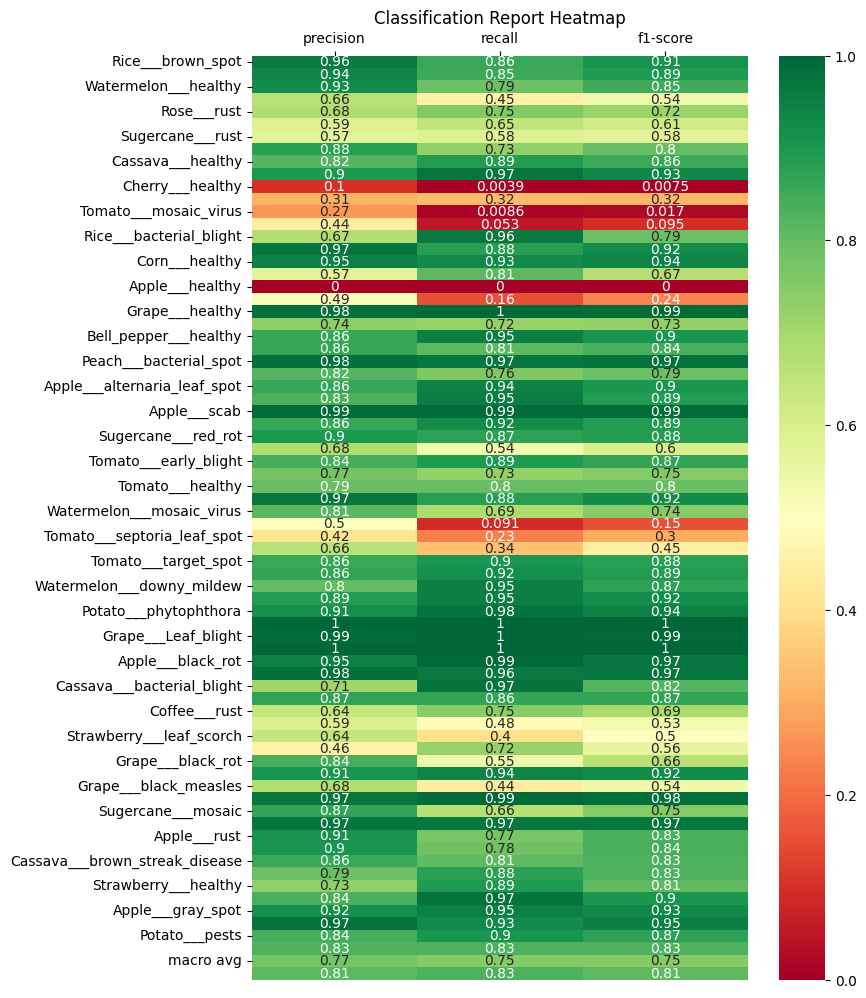

In [17]:
#generate and display Classification Report
class_report = classification_report(y, y_hat, target_names=classes, output_dict=True)

plt.figure(figsize=(8, 12))
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True, cmap="RdYlGn")
plt.title("Mock VGG-16 Classification Report")
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.show()

## 4. Testing different CNN Layers

I iteratively tested using different layers within the CNN, including changing the number of convolutional and FC layers and which layers to freeze, before I landed upon the CNN below as being the best balance between performance and efficiency. I found that there were too many convolutional layers in the VGG-16 model for the amount of data that I had. I also reduced the number of filters for each convolutional stack and traded layers.flatten for layers.GlobalAveragePooling2D to reduce dimensionality even more.

In [8]:
def custom_cnn(input_shape, nclasses):

    inputs = keras.Input(shape=input_shape)

    #Rescale pixels to [-1,1]
    x = layers.Rescaling(1./127.5, offset=-1.0)(inputs)

    #Stack 1 - convolution round 1, maxpooling
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    #Stack 2 - convolution round 2, maxpooling
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    #Stack 3 - Convolution round 3, maxpooling
    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    #reduces dimensionality
    x = layers.GlobalAveragePooling2D()(x)

    #drop 50% neurons to prevent overfitting before sending to FC layer
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x) #the only FC layer outside of the output layer
    x = layers.Dropout(0.5)(x) #drop 50% neurons to prevent overfitting before sending to output layer

    #output layer - softmax function
    outputs = layers.Dense(nclasses, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

#initialize input shape
input_shape = (256,256,3)
nclasses = 71

#create model object
cust_model = custom_cnn(input_shape, nclasses)

#compile model
cust_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

#print model summary
cust_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 71)             │         9,159 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,263 (1.76 MB)

 Trainable params: 460,263 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Early Stopping for efficiency
cust_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 3,
        mode='min',
        restore_best_weights=True)]

#start time
start = time.perf_counter()

#fit model and store epoch history
cust_history = cust_model.fit(
    data_tr,
    validation_data = data_ts,
    epochs=50,
    callbacks=cust_callbacks)

#end time
end = time.perf_counter()

print(f'Execution Time: {round(((end-start)/60),2)} Minutes')

Epoch 1/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 240s 165ms/step - accuracy: 0.4776 - loss: 1.8073 - val_accuracy: 0.6107 - val_loss: 1.3519
Epoch 2/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 240s 165ms/step - accuracy: 0.5532 - loss: 1.5094 - val_accuracy: 0.6771 - val_loss: 1.0989
Epoch 3/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 240s 165ms/step - accuracy: 0.6086 - loss: 1.2950 - val_accuracy: 0.7187 - val_loss: 0.9309
Epoch 4/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 240s 165ms/step - accuracy: 0.6576 - loss: 1.1186 - val_accuracy: 0.7554 - val_loss: 0.7883
Epoch 5/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 239s 165ms/step - accuracy: 0.6920 - loss: 0.9932 - val_accuracy: 0.7909 - val_loss: 0.6756
Epoch 6/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 240s 165ms/step - accuracy: 0.7151 - loss: 0.9094 - val_accuracy: 0.8129 - val_loss: 0.5800
Epoch 7/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 240s 165ms/step - accuracy: 0.7344 - loss: 0.8395 - val_accuracy: 0.8192 - val_loss: 0.5583
Epoch 8/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 240s 165ms/step - ac

### Browser Crash above ^^^

The browser crashed as it was running, but this model was having the best run I have seen yet. Unfortunately, when the browser crashed I lost all of the y-values and predictions as well. So, I cannot see what the precision/recall was like on this run. I will not run it again because I am assuming it will crash again due to insufficient memory.

In [ ]:
#predicting and storing values in y and y_hat
y_custom = []
yhat_custom = []
for images, label in data_ts:
    pred = model.predict(images, verbose=1)
    y_custom.extend(label.numpy())
    yhat_custom.extend(np.argmax(pred, axis=1))

#generate and display Classification Report
cust_class_report = classification_report(y_custom, yhat_custom, target_names=classes, output_dict=True)

plt.figure(figsize=(8, 12))
sns.heatmap(pd.DataFrame(cust_class_report).iloc[:-1, :].T, annot=True, cmap="RdYlGn")
plt.title("Custom CNN Classification Report")
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.show()

## 5. Reducing Data to only 21 Classes and ~56,000 samples

I decided to reduce the data to only 21 classes for three reasons:
1. It reduces the runtime of the model, so I could test more hyperparameters.
2. It improve the model performance by not needing to focus on underrepresented classes.
3. Fewer classes made it a little easier to investigate other ways in which performance was being impacted.

The small dataset only uses classes from the following plants: Cassava, Tomato, Potato, Rice, and Soybean. I chose these classes primarily for their class count, but also for their agricultural relevance. I used the custom_cnn for this dataset since it has a good balance between performance and efficiency.

In [6]:
#list of plants used in small dataset
small_lst = ["Cassava","Tomato", "Potato","Rice","Soybean"]

#creates the dataframe that summarizes the small dataset
df_small = df_class[df_class['plant'].isin(small_lst)]

#reduces the classes to only those that have over 1,000 samples
df_small = df_small[df_small['count'] >= 1000]

print(f"small nclasses: {len(df_small)}, nsamples= {df_small['count'].sum()}")
print(df_small.sort_values(by='count', ascending=False))
print(df_small['class'].tolist())

small nclasses: 21, nsamples= 56244.0
                             class   y    plant     health    count
45        Cassava___mosaic_disease  45  Cassava  unhealthy  13158.0
57              Tomato___leaf_curl  57   Tomato  unhealthy   5357.0
49               Soybean___healthy  49  Soybean    healthy   5090.0
17           Potato___early_blight  17   Potato  unhealthy   2628.0
8                Cassava___healthy   8  Cassava    healthy   2577.0
25          Cassava___green_mottle  25  Cassava  unhealthy   2386.0
35                Potato___healthy  35   Potato    healthy   2275.0
64  Cassava___brown_streak_disease  64  Cassava  unhealthy   2189.0
3          Tomato___bacterial_spot   3   Tomato  unhealthy   2127.0
47            Potato___late_blight  47   Potato  unhealthy   2087.0
55            Tomato___late_blight  55   Tomato  unhealthy   1909.0
38     Tomato___septoria_leaf_spot  38   Tomato  unhealthy   1771.0
11           Tomato___spider_mites  11   Tomato  unhealthy   1676.0
0         

In [11]:
small_dir = "/home/ryan/plants_small"

#initialize the train and test sets for the small dataset
small_tr, small_ts = tf.keras.preprocessing.image_dataset_from_directory(
                        small_dir,
                        labels='inferred',
                        label_mode = 'int',
                        batch_size=64,
                        image_size=(256,256),
                        shuffle=True,
                        seed = 42,
                        validation_split=0.2,
                        subset='both',
                        interpolation='lanczos3',
                        crop_to_aspect_ratio=True,
                        verbose=True)

#initialize input shape
input_shape = (256,256,3)
small_nclasses = len(df_small)
small_classes = small_tr.class_names

#create model object
small_model = custom_cnn(input_shape, small_nclasses)

#compile model
small_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

#Early Stopping for efficiency
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 3,
        mode='min',
        restore_best_weights=True)]

#fit model and store epoch history
history = small_model.fit(
    small_tr,
    validation_data = small_ts,
    epochs=50,
    callbacks=callbacks)

Found 56244 files belonging to 21 classes.
Using 44996 files for training.
Using 11248 files for validation.
Epoch 1/50
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.3539 - loss: 2.2176

2025-12-16 00:38:04.037037: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-16 00:38:04.037138: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-16 00:38:04.037150: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-16 00:38:04.037155: W external/loca

704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.3540 - loss: 2.2170

2025-12-16 00:38:12.090812: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-16 00:38:12.090858: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-16 00:38:12.595038: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_154', 4 bytes spill stores, 4 bytes spill loads

2025-12-16 00:38:12.774282: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Regi

704/704 ━━━━━━━━━━━━━━━━━━━━ 143s 199ms/step - accuracy: 0.4345 - loss: 1.8439 - val_accuracy: 0.5384 - val_loss: 1.3316
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 117s 166ms/step - accuracy: 0.5533 - loss: 1.3157 - val_accuracy: 0.6034 - val_loss: 1.1330
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - accuracy: 0.6124 - loss: 1.1264 - val_accuracy: 0.6749 - val_loss: 0.9602
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 117s 165ms/step - accuracy: 0.6526 - loss: 1.0123 - val_accuracy: 0.6987 - val_loss: 0.8490
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - accuracy: 0.6871 - loss: 0.9054 - val_accuracy: 0.7438 - val_loss: 0.7239
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - accuracy: 0.7108 - loss: 0.8322 - val_accuracy: 0.7475 - val_loss: 0.7243
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - accuracy: 0.7308 - loss: 0.7677 - val_accuracy: 0.7877 - val_loss: 0.5940
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - accuracy: 0.7510 - loss: 0.71

In [13]:
small_model.save("/home/ryan/cnn_small_final.keras")

## 6. Identifying the Data Imbalance Problem

Looking at the classification report and confusion matrix for only 21 classes made it a lot clearer that the model was struggling with classifying Cassava classes. This is becasue the Cassava___mosaic_disease class has so many more samples than any other class, so the model is leaning toward assigning any Cassava image as being part of the mosaic disease class.


2025-12-16 01:41:25.657562: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-16 01:41:25.657813: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-16 01:41:26.135436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_135', 4 bytes spill stores, 4 bytes spill loads

2025-12-16 01:41:26.401834: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Regi

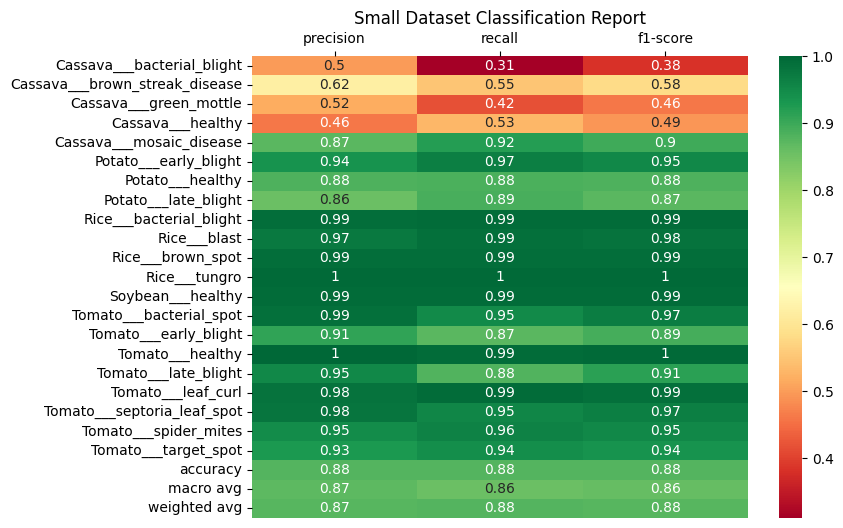

In [16]:
#predicting and storing values in y and y_hat
y_small = []
yhat_small = []
for images, label in small_ts:
    pred = small_model.predict(images, verbose=0)
    y_small.extend(label.numpy())
    yhat_small.extend(np.argmax(pred, axis=1))

#generates and display Classification Report
small_class_report = classification_report(y_small, yhat_small, target_names=small_classes, output_dict=True)

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(small_class_report).iloc[:-1, :].T, annot=True, cmap="RdYlGn")
plt.title("Small Dataset Classification Report")
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.show()

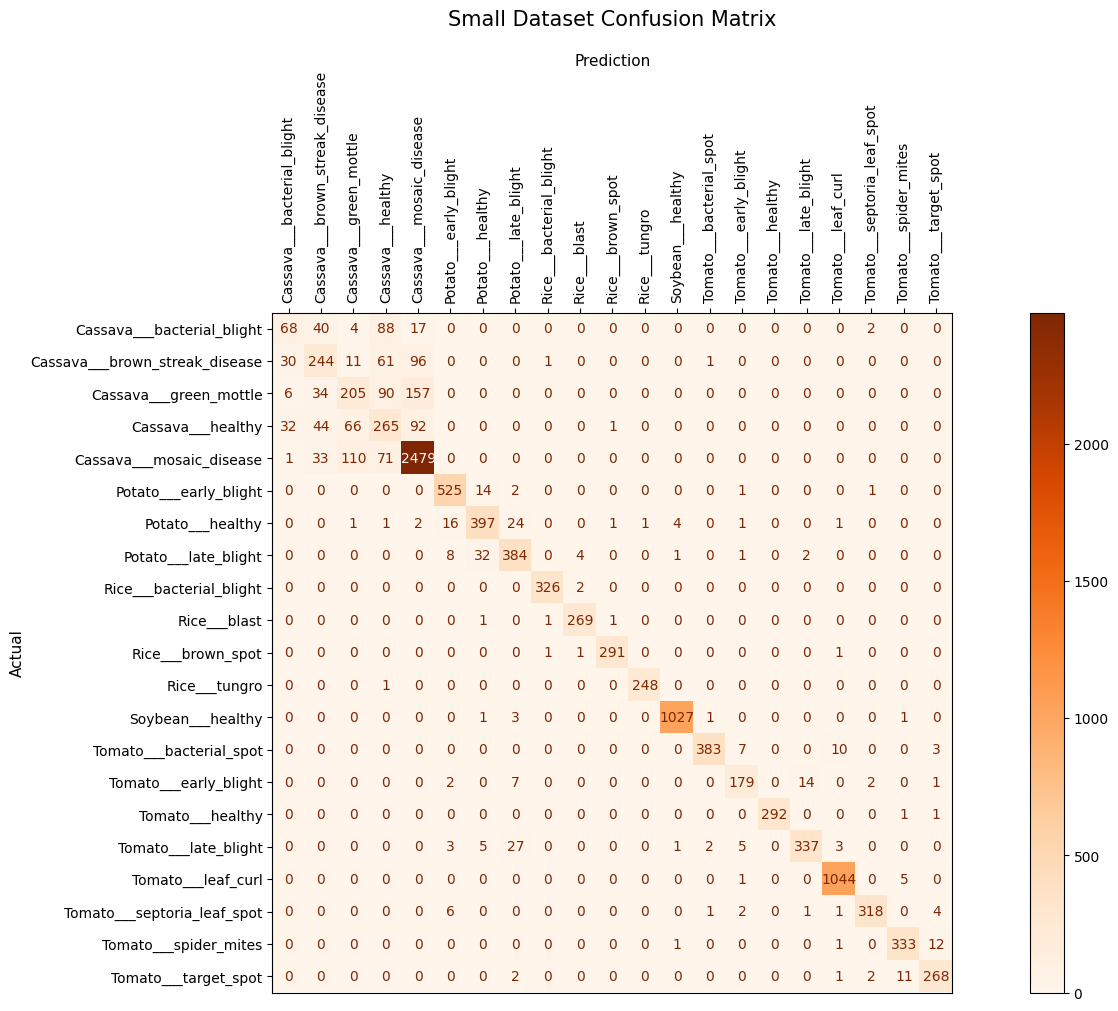

In [17]:
#generates and display confusion matrix
cm = confusion_matrix(y_small, yhat_small)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=small_classes)

fig, ax = plt.subplots(figsize=(20,10))
disp.plot(ax=ax,cmap='Oranges')
ax.tick_params(axis='x',labelrotation=90)
plt.title('Small Dataset Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xticks_rotation=90
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.show()

## 7. Using Class Weights to solve for imbalance

In [24]:
#gets the training label for each sample
train_labels = np.array(train_labels)

#computes the class weights
class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_labels),
    y = train_labels)

#creates dictionary of class weights
class_weights = dict(enumerate(class_weights))

#initialize input shape
input_shape = (256,256,3)
small_nclasses = len(df_small)
small_classes = small_tr.class_names

# #create model object
# weighted_model = custom_cnn(input_shape, small_nclasses)

# #compile model
# weighted_model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"])

#Early Stopping for efficiency
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 2,
        mode='min',
        restore_best_weights=True)]

#fit model and store epoch history
history =small_model.fit(
    small_tr,
    validation_data = small_ts,
    epochs=50,
    class_weight=class_weights, #uses class weights to fit model
    callbacks=callbacks)

Epoch 1/50


2025-12-16 01:44:43.444500: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-16 01:44:43.444552: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-16 01:44:44.292342: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1516', 120 bytes spill stores, 120 bytes spill loads

2025-12-16 01:44:44.358458: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7604 - loss: 1.4509

2025-12-16 01:46:36.680276: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-16 01:46:36.680324: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-12-16 01:46:37.131630: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1516', 120 bytes spill stores, 120 bytes spill loads

2025-12-16 01:46:37.401329: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

704/704 ━━━━━━━━━━━━━━━━━━━━ 124s 170ms/step - accuracy: 0.7798 - loss: 1.3097 - val_accuracy: 0.8132 - val_loss: 0.5665
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - accuracy: 0.8181 - loss: 1.0752 - val_accuracy: 0.8137 - val_loss: 0.5204
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - accuracy: 0.8344 - loss: 0.9814 - val_accuracy: 0.8423 - val_loss: 0.4441
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - accuracy: 0.8413 - loss: 0.9484 - val_accuracy: 0.8363 - val_loss: 0.4750
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 165ms/step - accuracy: 0.8529 - loss: 0.8906 - val_accuracy: 0.8247 - val_loss: 0.5032


2025-12-16 01:56:08.134987: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


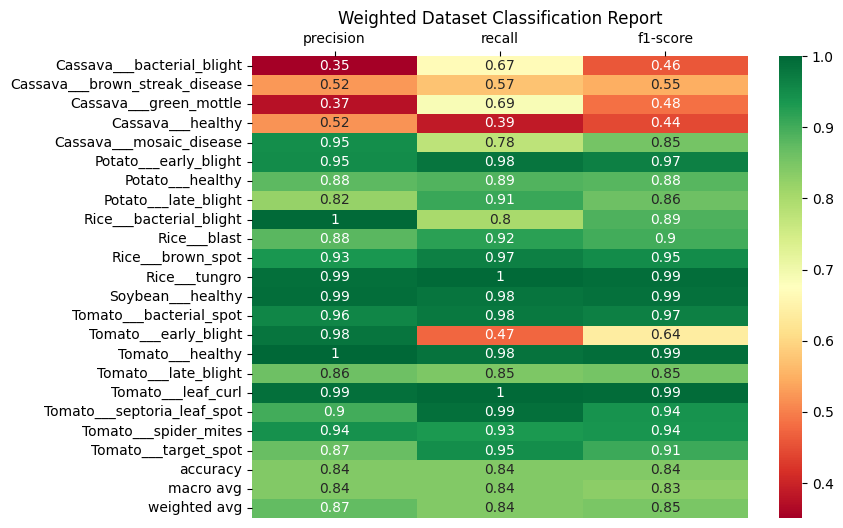

In [27]:
#predicting and storing values in y and y_hat
y_weighted = []
yhat_weighted = []
for images, label in small_ts:
    pred = small_model.predict(images, verbose=0)
    y_weighted.extend(label.numpy())
    yhat_weighted.extend(np.argmax(pred, axis=1))

#generates and display Classification Report
weighted_class_report = classification_report(y_weighted, yhat_weighted, target_names=small_classes, output_dict=True)

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(weighted_class_report).iloc[:-1, :].T, annot=True, cmap="RdYlGn")
plt.title("Weighted Dataset Classification Report")
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.show()

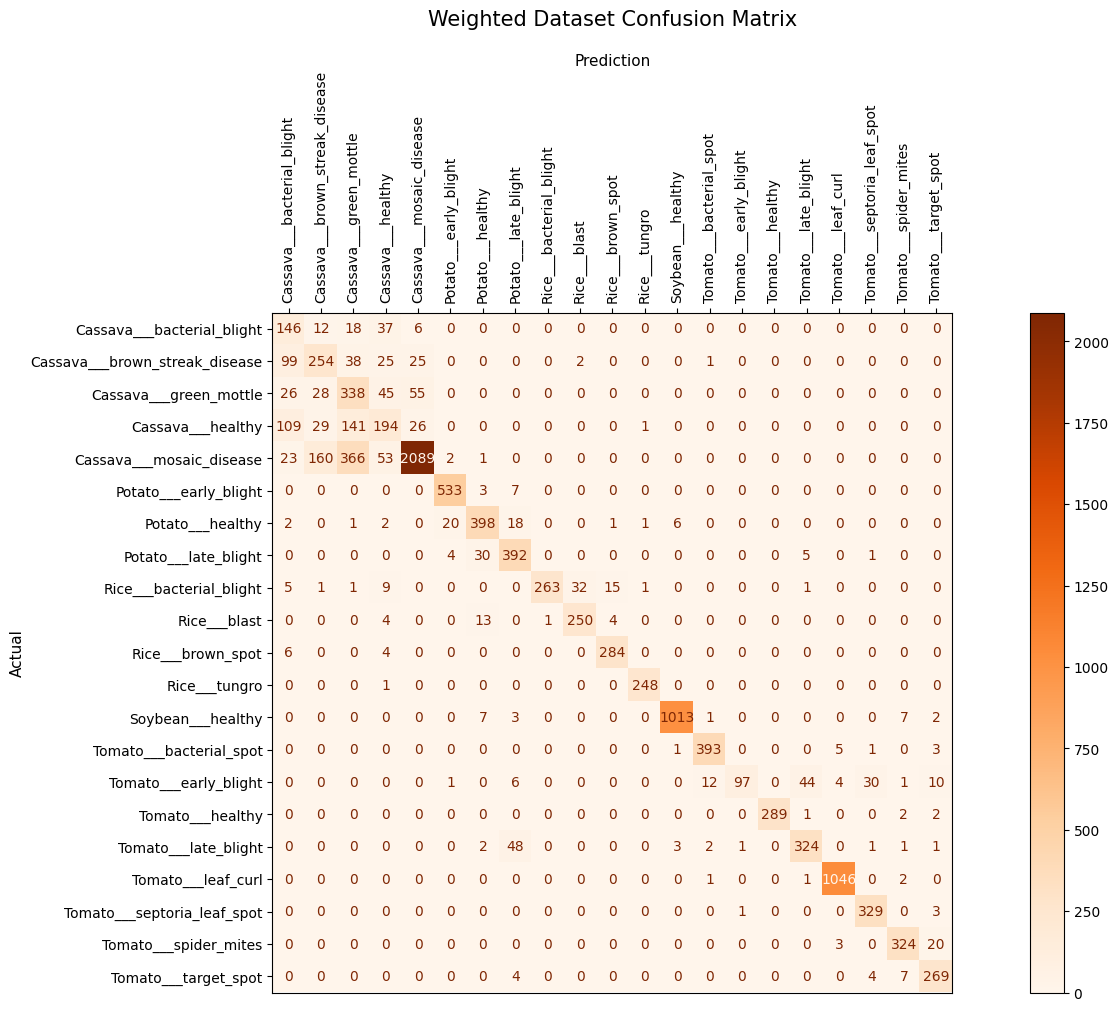

In [28]:
#generates and display confusion matrix
cm = confusion_matrix(y_weighted, yhat_weighted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=small_classes)

fig, ax = plt.subplots(figsize=(20,10))
disp.plot(ax=ax,cmap='Oranges')
ax.tick_params(axis='x',labelrotation=90)
plt.title('Weighted Dataset Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xticks_rotation=90
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)

plt.show()

### Weighted Confusion Matrix Above ^^^

The weighted classes fixed the problem with many non-mosaic disease cassava classes being assigned to mosaic disease, but now it has caused the Cassava Mosaic Disease to misclassify as all of the other Cassava classes. In some sense, the behavior is the opposite of what it was before the class weighting. And, the different Cassava classes are still being misclassified, now they just aren't all gravitating toward the mosaic disease misclassification.

## 8. Creating Stratified K-Fold to solve for imbalance (different Jupyter-Notebook)

I created this model in a different Jupyter Notebook becasue it was different enough than the above code, and so that it would not cause any issues with this notebook if anything were to go wrong during training (it took ~14 hours).

## 9. Augmented Data Function

I created this function to increase the training dataset by adding translations and rotations to the images. I ended up not being able to use this augmented data becuase my computer did not have enough memory to store the significantly larger dataset.

In [ ]:
autotune = tf.data.AUTOTUNE #used for dynamic adjustment of parallel calls for CPU

def augment_data(data_tr, data_ts):
    #reflect over y-axis (left-right)
    fliphor_tr = data_tr.map(lambda x,y: (tf.image.flip_left_right(x),y), num_parallel_calls=autotune)

    #flip image over x-axis (up-down)
    flipvert_tr = data_tr.map(lambda x,y: (tf.image.flip_up_down(x),y), num_parallel_calls=autotune)
    
    #rotate image 90 degrees (counter-clockwise)
    rot90_tr = data_tr.map(lambda x,y: (tf.image.rot90(x,k=1),y), num_parallel_calls=autotune)
    
    #rotate image 180 degrees
    rot180_tr = data_tr.map(lambda x,y: (tf.image.rot90(x,k=2),y), num_parallel_calls=autotune)
    
    #rotate image -90 degrees (clock-wise)
    rotneg90_tr = data_tr.map(lambda x,y: (tf.image.rot90(x,k=-1),y), num_parallel_calls=autotune)
    
    #combine original and transformed images to create one augmented dataset
    aug_tr = data_tr.concatenate(fliphor_tr).concatenate(flipvert_tr).concatenate(rot90_tr).concatenate(rot180_tr).concatenate(rotneg90_tr)
   
    #shuffle data and prefetch so CPU gets data while GPU calculates - reduces i/o latency
    aug_tr = aug_tr.shuffle(1000,seed=seed).prefetch(buffer_size=autotune)
    
    #cache stores dataset in memory and prefetch to reduce i/o latency
    data_ts = data_ts.cache().prefetch(buffer_size=autotune)

    return aug_tr, data_ts

aug_tr, aug_ts = augment_data(data_tr, data_ts)

print(f"Augmented dataset size: {len(aug_tr)*batch}")